### Code is modified from KaosEngineer https://github.com/KaosEngineer/PriorNetworks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.dirichlet import Dirichlet
import torch.optim as optim
from torch.distributions.kl import kl_divergence as KL
from torch.distributions.dirichlet import Dirichlet
from matplotlib import rc,ticker
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm
import matplotlib
import matplotlib.colors as mcolors

#Tuebingen color, set plot color
TUdark = (55 / 255, 65 / 255, 74 / 255)
rc("font", **{"family": "serif", "serif": ["Roboto Condensed"]})
rc("text", **{"color": TUdark})
rc("axes", **{"edgecolor": TUdark, "labelcolor": TUdark})
rc("xtick", **{"color": TUdark})
rc("ytick", **{"color": TUdark})
TUred = (165 / 255, 30 / 255, 55 / 255)
TUlight = (164 / 255, 163 / 255, 169/ 255)
TUdarklight = (231 / 255, 230 / 255, 231/ 255)

#SCI color 08 for clusters drawing
SCI081=(8 / 255, 51 / 255, 110 / 255) # dark blue
SCI082=(16 / 255, 92 / 255, 164 / 255) 
SCI083=(56 / 255, 136 / 255, 192 / 255) 
SCI084=(170 / 255, 207 / 255, 229 / 255) #light blue

#SCI color 07 for special points drawing
SCI071=(168 / 255, 3 / 255, 38 / 255) # red
SCI073=(122 / 255, 27 / 255,109 / 255)# purple
SCI072=(253 / 255,185 / 255,107 / 255)#orange yellow
SCI074=(254 / 255,251 / 255,186 / 255)# light yellow

/usr/local/lib/python3.7/dist-packages/sklearn/mixture/_base.py:282: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  ConvergenceWarning,
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


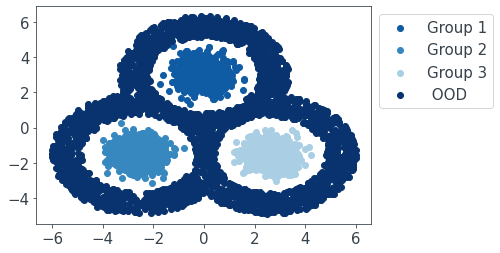

In [2]:
# Here we use the same way to build the dataset as shown in the paper RKI, code is from KaosEngineer
means = 3 * np.asarray([[0.0, 1.0],[-np.sqrt(3) / 2, -1.0 / 2],[np.sqrt(3) / 2, -1.0 / 2]])
weights = [1 / 3.0, 1 / 3.0, 1 / 3.0]
points=np.array([[0,6],[0,1.2],[4,2],[6,1.7],[0,12]])
np.random.seed(9876)
size = 1000
noise =0.5 #0.5,2
A = np.random.randn(size, 2) * noise + means[0]
B = np.random.randn(size, 2) * noise + means[1]
C = np.random.randn(size, 2) * noise + means[2]

data = np.concatenate((A, B, C), axis=0)

gmm = GMM(n_components=3,
          covariance_type='spherical',
          means_init=means,
          weights_init=weights,
          precisions_init=np.ones([3]) / noise,
          max_iter=1,
          random_state=1)
gmm.fit(data)
thresh = (norm.pdf(3.1)) ** 2
# thresh = (norm.pdf(6)) ** 2 # too loose
# thresh = (norm.pdf(2)) ** 2 # too tight
OOD_data = np.random.uniform(size=[1000000, 2], low=-30.0, high=30.0)
OOD_probs = np.exp(gmm.score_samples(OOD_data))

inds = (OOD_probs < thresh) & (OOD_probs > thresh/ 1000000) # good
OOD_data = OOD_data[inds]
OOD = OOD_data[:3 *size]

# plot
plt.scatter(A[:, 0], A[:, 1], color=SCI082,label='Group 1')
plt.scatter(B[:, 0], B[:, 1], color=SCI083,label='Group 2')
plt.scatter(C[:, 0], C[:, 1], color=SCI084,label='Group 3')
plt.scatter(OOD[:, 0], OOD[:, 1], color=SCI081,label=' OOD') # for paper
# plt.scatter(points[0,0],points[0,1],color=SCI071,label='In domain point',marker='D')
# plt.scatter(points[1,0],points[1,1],color='black',label='Strong data overlap',marker='D')
# plt.scatter(points[2,0],points[2,1],color=SCI073,label='Weak data overlap',marker='D')
# plt.scatter(points[4,0],points[4,1],color=SCI074,label='OOD point',marker='D')
# plt.legend(bbox_to_anchor =(1.25, 1))
plt.legend(bbox_to_anchor =(1, 1),fontsize=15)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.savefig("data_without.pdf",bbox_inches='tight',dpi=80)
plt.show()

# add labels, 3 categorize
A_label = np.ones((len(A), 3))
A_label[:, 0] = np.ones(len(A))*4

B_label = np.ones((len(B), 3))
B_label[:, 1] = np.ones(len(B))*4
 
C_label = np.ones((len(C), 3))
C_label[:, 2] = np.ones(len(C))*4

# all the label for OOD are 1
OOD_label = np.ones((len(OOD), 3))*1

# training data
X_train = np.concatenate([A,B,C,OOD])
y_train = np.concatenate([A_label,B_label,C_label,OOD_label])

# PriorNet

In [3]:
class PriorNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.FC1 = nn.Linear(2, 50)
        self.FC2 = nn.Linear(50, 3)    

    def forward(self, x):
        output = F.relu(self.FC1(x))
        return self.FC2(output)
        
    def alphas(self, x):
        return torch.exp(self.forward(torch.Tensor(x)))

    def uncertainty(self, x):
        alphas = self.alphas(x)
        alpha0 = torch.sum(alphas, dim=1, keepdim=True)
        probs = alphas / alpha0
        entropy = -torch.sum(probs*torch.log(probs), dim=1)
        data_uncertainty = -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
        diff_entropy = torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)
        return data_uncertainty,diff_entropy,entropy




In [4]:
#Training
model = PriorNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()


# Shuffling (very important)
arr = np.arange(len(X_train))
np.random.shuffle(arr)

X_train = X_train[arr]
y_train = y_train[arr]

for epoch in range(10):
  for i in range(len(X_train)):
    optimizer.zero_grad()
    gT = torch.Tensor(y_train[i])
    output = model.alphas(X_train[i])
    loss = KL(Dirichlet(output),Dirichlet(gT)) #RKL
    loss.backward()
    optimizer.step()
  print('Train Epoch:{}\t Loss:{:.3f}'.format(epoch, loss.item()))

Train Epoch:0	 Loss:0.083
Train Epoch:1	 Loss:0.030
Train Epoch:2	 Loss:0.027
Train Epoch:3	 Loss:0.021
Train Epoch:4	 Loss:0.017
Train Epoch:5	 Loss:0.015
Train Epoch:6	 Loss:0.015
Train Epoch:7	 Loss:0.013
Train Epoch:8	 Loss:0.012
Train Epoch:9	 Loss:0.010


In [5]:
#points with RKL
points=np.array([[0,6],[0,1.2],[4,2],[0,12]])
diff =[]
dc =[]
ent = []
ls = ["in domain:", " about center of the overlap:", "2 class strong overlap:","2 class less strong overlap:","OOD:"]
for i in range(len(points)):
  ret_dc, ret_dff, ret = model.uncertainty(points[i:i+1])
  ret_alp = model.alphas(points[i:i+1])
  print(ls[i],ret_alp.data,"data uncertainty",ret_dc.data)
  ent.append(ret.data.tolist()[0])
  diff.append(ret_dff.data.tolist()[0])
  dc.append(ret_dc.data.tolist()[0])

in domain: tensor([[0.9816, 1.1258, 1.0384]]) data uncertainty tensor([0.8416])
 about center of the overlap: tensor([[1.8245, 0.9199, 0.8150]]) data uncertainty tensor([0.8040])
2 class strong overlap: tensor([[0.7832, 1.1000, 0.8116]]) data uncertainty tensor([0.7998])
2 class less strong overlap: tensor([[0.0145, 0.9222, 0.8758]]) data uncertainty tensor([0.4974])


In [6]:
# Test set
X_test = np.empty([1,2]) #14
for i in np.arange(-6, 6, 0.1):
   for j in np.arange(-6, 6, 0.1):
      X_test = np.concatenate((X_test, [[i,j]]), axis=0)


In [7]:
diff =[]
dc =[]
ent = []
for i in range(len(X_test)):
  ret_dc, ret_dff, ret = model.uncertainty(X_test[i:i+1])
  ent.append(ret.data.tolist()[0])
  diff.append(ret_dff.data.tolist()[0])
  dc.append(ret_dc.data.tolist()[0])  

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


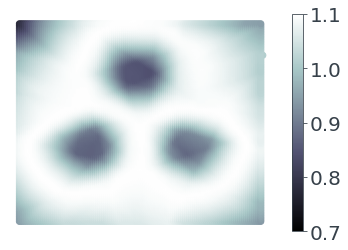

In [8]:
norm = mcolors.Normalize(1.1, 0.7)
cm = matplotlib.cm.get_cmap('bone')
plt.scatter(X_test[:,0],X_test[:,1],c=ent,cmap=cm,norm=norm)
plt.colorbar().ax.tick_params(labelsize=20)
plt.axis('off')
plt.savefig("RKL_entropy_without.pdf",dpi=40)

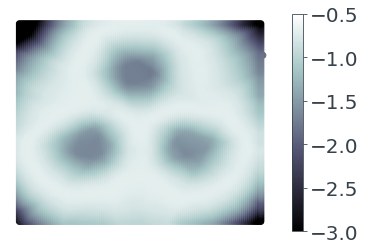

In [9]:
norm = mcolors.Normalize(-3, -0.5)
plt.scatter(X_test[:,0],X_test[:,1],c=diff,cmap=cm,norm=norm)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.axis('off')
plt.savefig('RKL_entropy_of_mu_without.pdf',dpi=40)

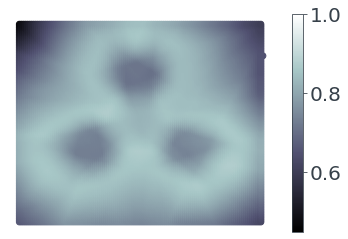

In [10]:
norm = mcolors.Normalize(0.45, 1)
plt.scatter(X_test[:,0],X_test[:,1],c=dc,cmap=cm,norm=norm)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=20)
plt.axis('off')
plt.savefig('RKL_data_uncertainty_without.pdf',dpi=40)

## Argmin KL(P||Q)

In [12]:
# def deri_general(s,p):
#   return -2*digamma(s)+2*digamma(p)+2*digamma(109)
# def func(q):
#   # x,y,z = q[0],q[1],q[2]
#   s = sum(q)
#   eq = []
#   for i in range(8):
#     eq.append(deri_general(s,q[i])-2*digamma(1))
#   eq.append(deri_general(s,q[-2])-digamma(1)-digamma(100))
#   eq.append(deri_general(s,q[-1])-digamma(1)-digamma(100))
#   return eq
#   # eq1 = deri_general(s,x)-2*digamma(1)
#   # eq2 = deri_general(s,y)-digamma(1)-digamma(100)
#   # eq3 = deri_general(s,z)-digamma(1)-digamma(100)
#   # return[eq1,eq2,eq3]
#   # return [-digamma(x+y+z)+digamma(x)-digamma(1),-2*digamma(x+y+z)+2*digamma(y)-digamma(1)-digamma(100)+2*digamma(102),-2*digamma(x+y+z)+2*digamma(z)-digamma(1)-digamma(100)+2*digamma(102)]


 
# result = fsolve(func,[1,1,1,1,1,1,1,1,1,1])
# result